# Encode to 2D with autoencoder

In [10]:
import json

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

from src.config import (
    SPECTROGRAM_PATH,
    MODEL_DIR,
    SOUND_PATH_LIST,
    SOUND_OUTPUT_PATH,
    RESULTS_DIR,
    SAMPLE_IDX,
    TO_PATHS
)
from src.dataset import SoundsDataset, ToTensor, LimitLength, Scale
from src.autoencoder_network import LSTMAutoEncoder

AE_MODEL_PATH = MODEL_DIR / "autoencoder_network.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
def train_network(net, dataloader, epochs, optimizer, criterion):

    for epoch in range(epochs):

        running_loss = 0.0
        for i, inputs in enumerate(dataloader):     
            optimizer.zero_grad()
            inputs = inputs.float().to(device)

            # Forward -> Backward -> Optimize
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print('[%d, %5d] loss: %.5f' %
                      (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0

In [3]:
transformations = transforms.Compose([ToTensor(), LimitLength(64), Scale()])
dataset = SoundsDataset(SPECTROGRAM_PATH, transform=transformations)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

input_dim = dataset[0].shape[-1]
encoding_size = 2
ae_net = LSTMAutoEncoder(input_dim, 256, encoding_size=encoding_size, encoder_layers=5).float().to(device)

In [4]:
epochs = 4
criterion = nn.MSELoss()
optimizer = optim.SGD(ae_net.parameters(), lr=0.005, momentum=0.9)

train_network(ae_net, dataloader, epochs, optimizer, criterion)

torch.save(ae_net.state_dict(), AE_MODEL_PATH)

[1,    20] loss: 0.40403
[1,    40] loss: 0.39242
[1,    60] loss: 0.39735
[1,    80] loss: 0.38633
[1,   100] loss: 0.35952
[1,   120] loss: 0.35869
[1,   140] loss: 0.35753
[1,   160] loss: 0.32828
[1,   180] loss: 0.33605
[1,   200] loss: 0.32149
[1,   220] loss: 0.30899
[2,    20] loss: 0.30051
[2,    40] loss: 0.27873
[2,    60] loss: 0.27183
[2,    80] loss: 0.26956
[2,   100] loss: 0.25187
[2,   120] loss: 0.24862
[2,   140] loss: 0.23383
[2,   160] loss: 0.22456
[2,   180] loss: 0.21769
[2,   200] loss: 0.20559
[2,   220] loss: 0.20182
[3,    20] loss: 0.18513
[3,    40] loss: 0.17405
[3,    60] loss: 0.17278
[3,    80] loss: 0.16795
[3,   100] loss: 0.16656
[3,   120] loss: 0.15511
[3,   140] loss: 0.15728
[3,   160] loss: 0.15978
[3,   180] loss: 0.15415
[3,   200] loss: 0.15363
[3,   220] loss: 0.15739
[4,    20] loss: 0.15517
[4,    40] loss: 0.15379
[4,    60] loss: 0.15632
[4,    80] loss: 0.15253
[4,   100] loss: 0.15543
[4,   120] loss: 0.15561
[4,   140] loss: 0.14825


In [5]:
ae_net.load_state_dict(torch.load(AE_MODEL_PATH))
ae_net.eval()

LSTMAutoEncoder(
  (lstm_encoder): LSTMEncoder(
    (encoder_lstm_list): ModuleList(
      (0): LSTM(128, 256, batch_first=True)
      (1): LSTM(256, 192, batch_first=True)
      (2): LSTM(192, 129, batch_first=True)
      (3): LSTM(129, 65, batch_first=True)
      (4): LSTM(65, 2, batch_first=True)
    )
  )
  (lstm_decoder): LSTMDecoder(
    (decoder_lstm_list): ModuleList(
      (0): LSTM(2, 65, batch_first=True)
      (1): LSTM(65, 129, batch_first=True)
      (2): LSTM(129, 192, batch_first=True)
      (3): LSTM(192, 256, batch_first=True)
    )
    (output_layer): Linear(in_features=256, out_features=128, bias=True)
  )
)

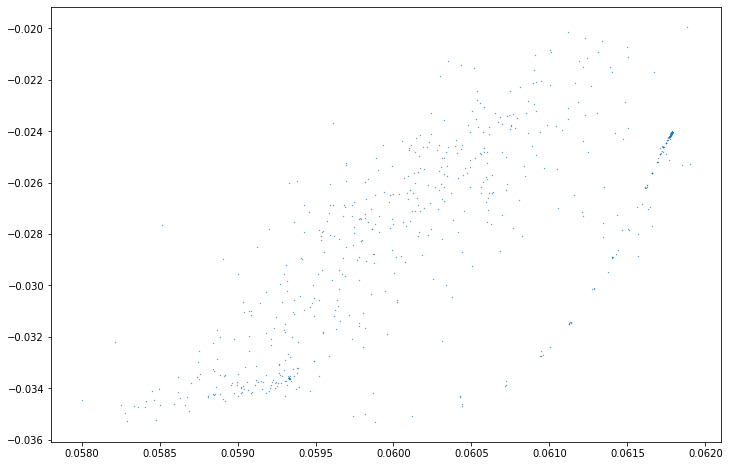

In [11]:
sample_tensor = np.array([dataset[i].numpy() for i in SAMPLE_IDX])
sample_tensor = torch.tensor(sample_tensor, dtype=torch.float).to(device)
latent = ae_net.encode(sample_tensor).detach().to("cpu").numpy()
latent = latent.reshape(latent.shape[0], latent.shape[2])

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(latent[:, 0], latent[:, 1], s=0.1)
plt.show()

In [12]:
results = {f"tsne_{i}": latent[:, i].tolist() for i in range(latent.shape[1])}
results["path"] = [path.split("/")[-1] for path in TO_PATHS]

with open(RESULTS_DIR / "ae_samples.json", "w") as fp:
    json.dump(results, fp)